In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense
from itertools import product
import seaborn as sns
import cleaning
import reinstancing

2025-04-21 19:08:09.023683: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-21 19:08:09.444755: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2025-04-21 19:08:09.444793: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-04-21 19:08:09.505369: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-21 19:08:11.180042: W tens

In [3]:
# Load and reinstance data
df_raw, users = cleaning.loadData('dataset_mood_smartphone.csv')
df_inst = reinstancing.reinstanceDataset(df_raw, users, period=5)
df_inst.head()


AS14.15  cannot provide subusers in ranges
AS14.20  cannot provide subusers in ranges


variable   activity  appCat.builtin  appCat.communication  \
AS14.01 0  0.163560     1370.685667           7502.876667   
        1  0.167999     1052.370500           7612.147000   
        2  0.152443     2607.564833           6929.466167   
        3  0.147191     2718.628833           6510.028333   
        4  0.134610     2643.197000           5181.341000   

variable   appCat.entertainment  appCat.finance  appCat.game  appCat.office  \
AS14.01 0            525.130333       40.585667     0.000000      29.202667   
        1            463.777500       39.364833     0.000000      30.910167   
        2            615.790667       50.713167    38.839333      30.910167   
        3            871.304500       43.479333    38.839333      30.910167   
        4            964.422167       37.795000    38.839333      30.408500   

variable   appCat.other  appCat.social  appCat.travel  appCat.unknown  \
AS14.01 0    125.598667    2597.354500     228.759167       39.203833   
        1     95.395500    2001.834667      84.070667       39.203833   
        2    116.696833    2014.019500     266.688000       39.203833   
        3    132.825333    1942.694333     275.427167       39.203833   
        4    134.066167    1433.370833     205.459667       50.283333   

variable   appCat.utilities  appCat.weather      call  circumplex.arousal  \
AS14.01 0        196.908500        5.064333  3.166667            0.458333   
        1        126.954333        5.064333  2.500000            0.375000   
        2        157.637000        5.064333  2.833333            0.291667   
        3        252.728833        0.000000  3.500000            0.125000   
        4        229.322833        0.000000  1.833333            0.000000   

variable   circumplex.valence      mood        screen       sms  nextday  
AS14.01 0            0.391304  6.416667  13973.567834  0.333333      6.6  
        1            0.478261  6.500000  13884.108333  0.500000      7.0  
        2            0.541667  6.625000  13680.996333  0.333333      6.4  
        3            0.500000  6.541667  13939.128000  0.500000      8.0  
        4            0.708333  6.958333  12185.105167  0.500000      7.5

In [4]:
# Feature engineering
df_feat = df_inst.copy()
df_feat['screen_log'] = np.log1p(df_feat['screen'])
df_feat['activity_log'] = np.log1p(df_feat['activity'])
df_feat['call_sms_ratio'] = df_feat['call'] / (df_feat['sms'] + 1)
df_feat = df_feat.dropna()
df_feat['mood_cat'] = pd.qcut(df_feat['nextday'], 5, labels=False)
df_feat.head()


variable   activity  appCat.builtin  appCat.communication  \
AS14.01 0  0.163560     1370.685667           7502.876667   
        1  0.167999     1052.370500           7612.147000   
        2  0.152443     2607.564833           6929.466167   
        3  0.147191     2718.628833           6510.028333   
        4  0.134610     2643.197000           5181.341000   

variable   appCat.entertainment  appCat.finance  appCat.game  appCat.office  \
AS14.01 0            525.130333       40.585667     0.000000      29.202667   
        1            463.777500       39.364833     0.000000      30.910167   
        2            615.790667       50.713167    38.839333      30.910167   
        3            871.304500       43.479333    38.839333      30.910167   
        4            964.422167       37.795000    38.839333      30.408500   

variable   appCat.other  appCat.social  appCat.travel  ...  \
AS14.01 0    125.598667    2597.354500     228.759167  ...   
        1     95.395500    2001.834667      84.070667  ...   
        2    116.696833    2014.019500     266.688000  ...   
        3    132.825333    1942.694333     275.427167  ...   
        4    134.066167    1433.370833     205.459667  ...   

variable   circumplex.arousal  circumplex.valence      mood        screen  \
AS14.01 0            0.458333            0.391304  6.416667  13973.567834   
        1            0.375000            0.478261  6.500000  13884.108333   
        2            0.291667            0.541667  6.625000  13680.996333   
        3            0.125000            0.500000  6.541667  13939.128000   
        4            0.000000            0.708333  6.958333  12185.105167   

variable        sms  nextday  screen_log  activity_log  call_sms_ratio  \
AS14.01 0  0.333333      6.6    9.544994      0.151485        2.375000   
        1  0.500000      7.0    9.538572      0.155292        1.666667   
        2  0.333333      6.4    9.523836      0.141884        2.125000   
        3  0.500000      8.0    9.542527      0.137316        2.333333   
        4  0.500000      7.5    9.408052      0.126289        1.222222   

variable   mood_cat  
AS14.01 0         1  
        1         1  
        2         0  
        3         4  
        4         3  

[5 rows x 24 columns]

In [5]:
# Prepare train/test split
X = df_feat.drop(columns=['nextday', 'mood_cat'])
y = df_feat['mood_cat']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/3, stratify=y, random_state=42
 )


In [6]:
# Scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


In [7]:
# Random Forest hyperparameter tuning
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50,100,200,300],
    'max_depth':    [None,10,20,30],
    'min_samples_split': [2,5,10],
    'min_samples_leaf':  [1,2,4],
    'max_features': ['auto','sqrt'],
    'bootstrap':    [True, False]
}

grid_rf = GridSearchCV(
    rf,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)
grid_rf.fit(X_train_s, y_train)

print('Best RF params:', grid_rf.best_params_)
print('Best RF CV accuracy:', grid_rf.best_score_)
y_pred_rf = grid_rf.best_estimator_.predict(X_test_s)
print(classification_report(y_test, y_pred_rf))

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.7s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.8s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.2s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.2s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.6s[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.5s

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.7s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   2.2s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.7s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.1s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   2.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.8s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.8s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.9s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   2.8s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   1.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   1.8s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.9s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.7s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth

/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.9s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.9s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.6s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.9s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.9s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.9s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.3s

/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.0s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.0s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   1.6s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   1.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.0s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_featu

/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.7s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.0s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.4s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.4s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.2s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.6s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.6s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.7s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.7s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.0s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.7s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.7s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.1s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.6s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.5s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.2s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.7s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.7s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.0s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.6s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.7s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.0s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.0s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   1.4s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   1.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   1.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.1s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.5s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.5s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=20, max_featu

/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.1s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.4s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.7s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.8s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.7s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.0s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.1s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.8s[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.7s

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.1s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   2.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   2.1s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.8s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   2.8s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   2.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   2.2s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.0s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.4s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   2.7s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   3.3s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.2s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.0s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.1s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.9s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.6s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.8s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   2.2s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   2.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   2.4s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   1.6s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.8s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.8s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   2.1s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.1s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.8s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   2.6s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   2.1s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   2.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=30, max_featu

/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.6s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.0s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.9s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.8s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.9s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   2.1s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.1s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.8s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.4s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   2.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.7s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.3s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.3s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.9s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.3s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.3s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.8s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.1s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.0s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.6s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.7s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.4s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.0s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.3s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.3s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.8s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   1.2s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   1.3s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   1.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.1s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.3s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.6s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, m

/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.9s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.2s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.8s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.5s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.8s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.8s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   2.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   2.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.6s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.8s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.1s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.1s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   2.6s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   2.9s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.3s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.6s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.7s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.9s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.3s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.4s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.8s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.9s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.3s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.7s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.3s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.9s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.8s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   1.2s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   1.5s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   1.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, m

/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.9s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.9s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.2s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.3s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.5s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.7s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.5s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.9s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.1s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.1s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.8s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.7s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.3s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.2s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.8s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.3s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.6s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.7s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.0s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.4s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.1s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.9s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.3s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.4s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.6s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.9s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.4s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.8s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   1.3s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   1.3s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   1.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.0s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.0s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.4s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.7s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, m

/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.8s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.4s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.5s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.0s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.0s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.3s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.3s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.9s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.3s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.0s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.0s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.5s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.3s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.9s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.3s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.8s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   1.2s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   1.2s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   1.3s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.8s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.4s


/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.3s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=30, 

/home/pjotr/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best RF params: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best RF CV accuracy: 0.4273809523809524
              precision    recall  f1-score   support

           0       0.61      0.47      0.53        53
           1       0.37      0.65      0.47        74
           2       1.00      0.04      0.08        23
           3       0.38      0.30      0.33        50
           4       0.50      0.34      0.41        41

    accuracy                           0.43       241
   macro avg       0.57      0.36      0.36       241
weighted avg       0.50      0.43      0.41       241



In [ ]:
param_grid = {
    'n_estimators':      [50, 100, 200, 300],
    'max_depth':         [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4],
    'max_features':      ['sqrt', 'log2', None],  # dropped 'auto'
    'bootstrap':         [True, False],
}

# Generate every combination
keys, values = zip(*param_grid.items())
combos = [dict(zip(keys, v)) for v in product(*values)]

# Run CV for each combo
results = []
for params in combos:
    rf = RandomForestClassifier(**params, random_state=42)
    scores = cross_val_score(
        rf, X_train_s, y_train,
        cv=3, scoring='accuracy', n_jobs=-1
    )
    results.append({**params, 'mean_score': scores.mean()})

df_res = pd.DataFrame(results)

# Pivot & fill
heatmap_data = (
    df_res
    .pivot_table(
        index='n_estimators',
        columns='max_depth',
        values='mean_score',
        aggfunc='mean'
    )
    .fillna(df_res['mean_score'].min())
)

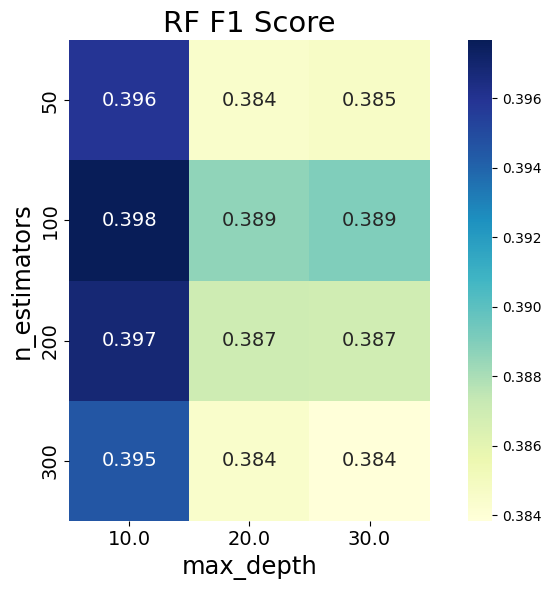

In [18]:
# Define a text scale factor
scale_factor = 1.75  # Adjust this to increase/decrease all text sizes

# Fixed figure size
fig_width = 8
fig_height = 6

# Plot
plt.figure(figsize=(fig_width, fig_height))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.3f',
    cmap='YlGnBu',
    square=True,
    annot_kws={"fontsize": 8 * scale_factor}
)
plt.title("RF F1 Score", fontsize=12 * scale_factor)
plt.xlabel("max_depth", fontsize=10 * scale_factor)
plt.ylabel("n_estimators", fontsize=10 * scale_factor)
plt.xticks(fontsize=8 * scale_factor)
plt.yticks(fontsize=8 * scale_factor)
plt.tight_layout()
plt.savefig('RFhyp.pdf', dpi=300)
plt.show()


# RNN hyperparameter tuning


In [9]:
# Prepare data for RNN
X_train_rnn = X_train_s.reshape((X_train_s.shape[0], 1, X_train_s.shape[1]))
X_test_rnn = X_test_s.reshape((X_test_s.shape[0], 1, X_test_s.shape[1]))


In [10]:
# RNN hyperparameter tuning
n_features = X_train_s.shape[1]
def create_model(units=64, dropout_rate=0.5, optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(units, activation='relu', input_shape=(1, n_features)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(5, activation='softmax'))
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model
rnn = KerasClassifier(build_fn=create_model, verbose=0)
param_grid_rnn = {
    'units': [32,64],
    'dropout_rate': [0.2,0.5],
    'optimizer': ['adam','rmsprop'],
    'batch_size': [16,32],
    'epochs': [10,20]
}

grid_rnn = GridSearchCV(
    rnn,
    param_grid=param_grid_rnn,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=1
)
grid_rnn.fit(X_train_rnn, y_train)
print('Best RNN params:', grid_rnn.best_params_)
print('Best RNN CV accuracy:', grid_rnn.best_score_)


/tmp/ipykernel_10792/1488566211.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  rnn = KerasClassifier(build_fn=create_model, verbose=0)
2025-04-21 19:20:29.546151: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2025-04-21 19:20:29.546698: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-04-21 19:20:29.547418: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pjotr-Lenovo-YOGA-530-14IKB): /proc/driver/nvidia/version does not exist
2025-04-21 19:20:29.551738: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimi

Fitting 3 folds for each of 32 candidates, totalling 96 fits
6/6 [==============================] - 0s 2ms/step
[CV] END batch_size=16, dropout_rate=0.2, epochs=10, optimizer=adam, units=32; total time=   3.1s
6/6 [==============================] - 0s 1ms/step
[CV] END batch_size=16, dropout_rate=0.2, epochs=10, optimizer=adam, units=32; total time=   2.1s
5/5 [==============================] - 0s 2ms/step
[CV] END batch_size=16, dropout_rate=0.2, epochs=10, optimizer=adam, units=32; total time=   2.1s
6/6 [==============================] - 0s 2ms/step
[CV] END batch_size=16, dropout_rate=0.2, epochs=10, optimizer=adam, units=64; total time=   2.3s
6/6 [==============================] - 0s 1ms/step
[CV] END batch_size=16, dropout_rate=0.2, epochs=10, optimizer=adam, units=64; total time=   2.5s
5/5 [==============================] - 0s 2ms/step
[CV] END batch_size=16, dropout_rate=0.2, epochs=10, optimizer=adam, units=64; total time=   1.9s
6/6 [==============================] - 0s 2ms

KeyboardInterrupt: 